In [1]:
import pandas as pd
import csv
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("Root_Insurance_data.csv",delimiter = ",")

In [3]:
## Input: Data Frame (in the format of "Root_Insurance_data.csv") and encode_rank (default = False)
## Output: Data Frame (processed by one hot encoding ready to be used to make models)

## This function will one hot encode the following columns in the data frame: 
## Currently Insured, Marital Status, click, rank (optional, determined by encode_rank = True)
## and will drop the respective columns associated to the respective values of above columns:
## unknown, S, False, 5.0 (if encode_rank = True)

import category_encoders as ce

def prepare_data(data:pd.DataFrame(), encode_rank = False, drop_column = False) -> pd.DataFrame():
    temp = data.copy()
    
    if encode_rank:
        one_hot_cols = ["Currently Insured", "Marital Status", "click", "rank"]
        drop_cols = ["Currently Insured_unknown", "Marital Status_S", "rank_5.0", "click_False"]
        column_names = ['Currently Insured_Y', 'Currently Insured_N', 'Number of Vehicles',
                        'Number of Drivers', 'Marital Status_M', 'bid', 'rank_1.0',
                        'rank_2.0', 'rank_3.0', 'rank_4.0', 'click_True', 'policies_sold']
    else:
        one_hot_cols = ["Currently Insured", "Marital Status", "click"]
        drop_cols = ["Currently Insured_unknown", "Marital Status_S", "click_False"]
        column_names = ['Currently Insured_Y', 'Currently Insured_N', 'Number of Vehicles','Number of Drivers',
                        'Marital Status_M', 'bid', 'rank', 'click_True', 'policies_sold']
    
    encoder = ce.OneHotEncoder(cols = one_hot_cols, use_cat_names = True)
    temp = encoder.fit_transform(temp)
    temp = temp.drop(columns = drop_cols)
    temp = temp.reindex(columns=column_names)
    return temp

In [4]:
df = prepare_data(data)

C:\Users\David\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, accuracy_score

features = ['Currently Insured_Y',
            'Currently Insured_N',
            'Number of Vehicles',
            'Number of Drivers',
            'Marital Status_M',
            'rank']
predictor_var = "click_True"

df_train, df_test = train_test_split(df,
                                     shuffle=True,
                                     random_state=12345,
                                     test_size=.2,
                                     stratify=df[predictor_var])

In [6]:
## Allows for variantion of resampling with condition resampling = "None", "Up", "Down" or "Balanced"

from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample,shuffle

c_values = [.03, .1, .3, 1, 3, 10, 30, 100]

def obtain_log_scores(data:pd.DataFrame(), num_of_splits = 5, resampling = "None") -> []:
    avg_precision_cross_val = np.zeros((num_of_splits,len(c_values)))
    roc_auc_cross_val = np.zeros((num_of_splits,len(c_values))) 
    accuracy_cross_val = np.zeros((num_of_splits,len(c_values)))  

    kfold = StratifiedKFold(n_splits=num_of_splits, shuffle=True, random_state=77)
    
    i = 0
    for train_index, test_index in kfold.split(df_train[features], df_train[predictor_var]):
        df_train_train = resample_data(data.iloc[train_index], resample_type = resampling)
        df_train_val = data.iloc[test_index]
        
        j = 0
        for c in c_values:
            log_reg = LogisticRegression(C=c)
            log_reg.fit(df_train_train[features], df_train_train[predictor_var])

            avg_precision_cross_val[i,j] = average_precision_score(df_train_val[predictor_var], 
                                                                 log_reg.predict_proba(df_train_val[features])[:,1])
            roc_auc_cross_val[i,j] = roc_auc_score(df_train_val[predictor_var], 
                                                 log_reg.predict_proba(df_train_val[features])[:,1])
            accuracy_cross_val[i,j] = accuracy_score(df_train_val[predictor_var], 
                                                   log_reg.predict(df_train_val[features]))
            j += 1
        i += 1
    
    return [avg_precision_cross_val, roc_auc_cross_val, accuracy_cross_val]

def resample_data(df:pd.DataFrame(), resample_type = "None") -> pd.DataFrame():
    df_minority = df[df[predictor_var] == 1]
    df_majority = df[df[predictor_var] != 1]
    if resample_type == "Up":
        df_minority_up = resample(df_minority,
                                  random_state=886,
                                  n_samples=len(df_majority),
                                  replace=True)
        df_resampled = pd.concat([df_minority_up, df_majority]).sample(frac=1, random_state = 0)
    elif resample_type == "Down":
        df_majority_down = resample(df_majority,
                                    random_state=886,
                                    n_samples=len(df_minority),
                                    replace=True)
        df_resampled = pd.concat([df_majority_down, df_minority]).sample(frac=1, random_state = 0)
    elif resample_type == "Balanced":
        df_majority_bal = resample(df_majority,
                                           random_state=886,
                                           n_samples= int(len(df)/2),
                                           replace=True)
        df_minority_bal = resample(df_minority,
                                               random_state=886,
                                               n_samples=int(len(df)/2),
                                               replace=True)
        df_resampled = pd.concat([df_majority_bal, df_minority_bal]).sample(frac=1, random_state = 0)  
    else:
        df_resampled = df
    return df_resampled


In [7]:
def plot_charts(avg_precision_avg_val, roc_auc_avg_val, accuracy_avg_val):
    X = [str(x) for x in c_values]
    plt.scatter(X, avg_precision_avg_val, label="AUCPR")
    plt.scatter(X, roc_auc_avg_val, label="AUCROC")
    plt.scatter(X, accuracy_avg_val, label="Accuracy")
    plt.legend()
    plt.xlabel("c value")
    plt.ylabel("avg_cross_val")
    plt.ylim(0,1)
    plt.show()
    print("C value with highest of AUCPR is: " + str(np.argmax(avg_precision_avg_val) + 1))
    print("with AUCPR = " + str(avg_precision_avg_val[np.argmax(avg_precision_avg_val)]))
    print()
    print("C value with highest of AUCROC is: " + str(np.argmax(roc_auc_avg_val) + 1))
    print("with AUCPR = " + str(roc_auc_avg_val[np.argmax(roc_auc_avg_val)]))
    print()
    print("C value with highest of Accuracy is: " + str(np.argmax(accuracy_avg_val) + 1))
    print("with AUCPR = " + str(accuracy_avg_val[np.argmax(accuracy_avg_val)]))

### No Resample Case

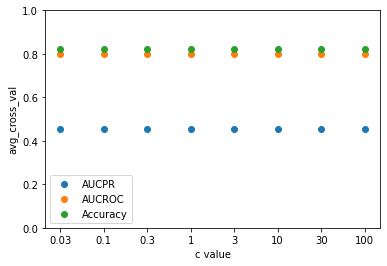

C value with highest of AUCPR is: 1
with AUCPR = 0.4557409419010937

C value with highest of AUCROC is: 5
with AUCPR = 0.7982662776670489

C value with highest of Accuracy is: 2
with AUCPR = 0.8217500000000001


In [8]:
avg_precision_cross_val, roc_auc_cross_val, accuracy_cross_val = obtain_log_scores(df_train)
avg_precision_avg_val = np.average(avg_precision_cross_val, axis=0)
roc_auc_avg_val = np.average(roc_auc_cross_val, axis=0)
accuracy_avg_val = np.average(accuracy_cross_val, axis=0)

plot_charts(avg_precision_avg_val, roc_auc_avg_val, accuracy_avg_val)

### Upsample Case

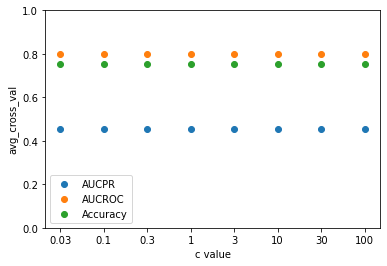

C value with highest of AUCPR is: 3
with AUCPR = 0.4553931564383153

C value with highest of AUCROC is: 2
with AUCPR = 0.7979486622649242

C value with highest of Accuracy is: 1
with AUCPR = 0.7525000000000001


In [9]:
avg_precision_cross_val_up, roc_auc_cross_val_up, accuracy_cross_val_up = obtain_log_scores(df_train, resampling = "Up")
avg_precision_avg_val_up = np.average(avg_precision_cross_val_up, axis=0)
roc_auc_avg_val_up = np.average(roc_auc_cross_val_up, axis=0)
accuracy_avg_val_up = np.average(accuracy_cross_val_up, axis=0)

plot_charts(avg_precision_avg_val_up, roc_auc_avg_val_up, accuracy_avg_val_up)

### Downsample Case

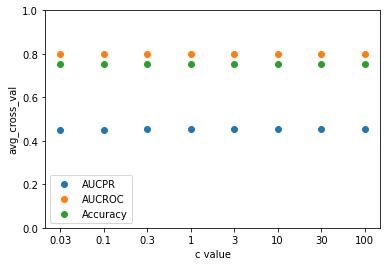

C value with highest of AUCPR is: 5
with AUCPR = 0.4524285994877652

C value with highest of AUCROC is: 5
with AUCPR = 0.7975876706904816

C value with highest of Accuracy is: 3
with AUCPR = 0.7525000000000001


In [10]:
avg_precision_cross_val_down, roc_auc_cross_val_down, accuracy_cross_val_down = obtain_log_scores(df_train, resampling = "Down")
avg_precision_avg_val_down = np.average(avg_precision_cross_val_down, axis=0)
roc_auc_avg_val_down = np.average(roc_auc_cross_val_down, axis=0)
accuracy_avg_val_down = np.average(accuracy_cross_val_down, axis=0)

plot_charts(avg_precision_avg_val_down, roc_auc_avg_val_down, accuracy_avg_val_down)

### Balanced Sampling Case

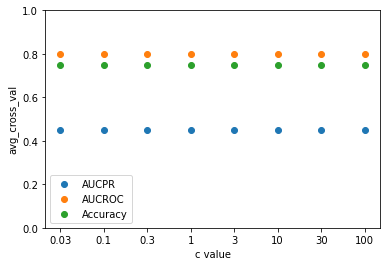

C value with highest of AUCPR is: 1
with AUCPR = 0.44995509120925303

C value with highest of AUCROC is: 4
with AUCPR = 0.7974609254086229

C value with highest of Accuracy is: 1
with AUCPR = 0.7497499999999999


In [11]:
avg_precision_cross_val_bal, roc_auc_cross_val_bal, accuracy_cross_val_bal = obtain_log_scores(df_train, resampling = "Balanced")
avg_precision_avg_val_bal = np.average(avg_precision_cross_val_bal, axis=0)
roc_auc_avg_val_bal = np.average(roc_auc_cross_val_bal, axis=0)
accuracy_avg_val_bal = np.average(accuracy_cross_val_bal, axis=0)

plot_charts(avg_precision_avg_val_bal, roc_auc_avg_val_bal, accuracy_avg_val_bal)